Évaluation des résultats de lemmatisation 
==================================

## Objectifs

1. Lecture des logs
2. Alignement avec types de modèles
3. Lectures des résultats

## Data acquisition

In [15]:
import glob

# IMPORTANT: THIS IS HARD CODED, SUPPORT FOR ALL LEMMA FROM DEV SET

nb_words_dev_set = 40812


models = [
    
]
ModelScheme = {
    "config": "",
    "tar": "",
}
file = "grc.log"
tasks = []
with open(file) as f:
    config = None
    current_task = None
    current = {
        "scores": {},
        "eval-time": []
    }
    for line in f:
        if line.startswith("config_path: "):
            current["config"] = line.strip()[len("config_path: "):]
        elif "Bye" in line.strip():
            models.append(current)
            current = {
                "scores": {},
                "eval-time": []
            }
            current_task = None
        elif line.startswith("#"):
            current_task = line.strip()[len("## "):]
            tasks.append(current_task)
            current["scores"][current_task] = {}
            current["task"] = current_task
        elif current_task and line.startswith("|"):  # We already have a task recorded
            cat, acc, pre, rec, sup = [x.strip() for x in line.strip().split("|") if x]
            if sup == "support" or "---" in sup:
                continue
            current["scores"][current_task][cat] = (float(acc), float(pre), float(rec), int(sup))
        elif ".tar" in line:
            current["file"] = line.strip()[len("Saved best model to: ["):-1]
        elif "Finished training in " in line:
            current["training-time"] = float(line.strip()[len("2020-04-23 23:13:33,251 : Finished training in ["):-1])
        elif "Starting epoch" in line:
            current["nb-epochs"] = int(line.strip()[len("2020-04-23 20:23:00,051 : Starting epoch ["):-1])
        elif "Evaluation time: " in line:
            current["eval-time"].append(
                float(line.strip()[len("2020-04-24 04:04:56,425 : Evaluation time: "):-len(" sec")])
            )

models = {
    model["file"]: model for model in models
}
tasks = {
    task: [model for model in models.values() if model["task"] == task]
    for task in tasks
}

In [30]:
column = [
    "file", "task", 
    "acc", "acc-amb", "acc-unk-tok",
    "All support", "amb-tar-support", "Unk-toks-support", 
    #"training-time", 
    #"nb-epochs", 
    #"Sec / Epoch",
    #"Average Dev Test Time",
    #"sec / 1000 words"
]

files = sorted(list(models.keys()))

table = []
for task, files in tasks.items():
    print(task)
    for model in files:
        table.append([
            model["file"],
            task,
            # Accuracies
            model["scores"][task]["all"][0],
            model["scores"][task]["ambiguous-tokens"][0],
            model["scores"][task]["unknown-tokens"][0],
            # Supports
            model["scores"][task]["all"][-1],
            model["scores"][task]["ambiguous-tokens"][-1],
            model["scores"][task]["unknown-tokens"][-1],
            # Time
            #model.get("training-time", 0),
            #model["nb-epochs"],
            #round(model.get("training-time", 0) / model["nb-epochs"], 2),
            # Inference time
            #round(sum(model["eval-time"][1:]) / len(model["eval-time"][1:]), 2),
            #round(
            #    nb_words_dev_set /
            #    (sum(model["eval-time"][1:]) / len(model["eval-time"][1:]))
            #    , 2
            #)

        ])
    
table = sorted(table, key=lambda x: x[2])  # 2 is acc, 3 amb, 5 tokens
table = [column] + table

case
degree
gend
lemma
mood
num
pers
pos
tense
voice


In [31]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(table, tablefmt='html')))

file,task,acc,acc-amb,acc-unk-tok,All support,amb-tar-support,Unk-toks-support
./models/greek-pos-pos-2021_02_07-10_03_16.tar,pos,0.924,0.8729,0.8695,71235,35335,4990
./models/greek-pos-pos-2021_02_06-05_45_39.tar,pos,0.9243,0.876,0.8667,71235,35335,4990
./models/greek-pos-pos-2021_02_08-13_46_29.tar,pos,0.925,0.8751,0.8729,71235,35335,4990
./models/greek-pos-pos-2021_02_10-19_36_43.tar,pos,0.925,0.874,0.8737,71235,35335,4990
./models/greek-pos-pos-2021_02_09-16_12_14.tar,pos,0.9287,0.8805,0.8898,71235,35335,4990
./models/greek-gend-gend-2021_02_07-22_05_09.tar,gend,0.941,0.8223,0.818,71235,15473,4990
./models/greek-gend-gend-2021_02_06-18_31_10.tar,gend,0.9427,0.8278,0.8166,71235,15473,4990
./models/greek-gend-gend-2021_02_10-05_24_38.tar,gend,0.9433,0.8279,0.822,71235,15473,4990
./models/greek-gend-gend-2021_02_09-02_07_49.tar,gend,0.9434,0.8278,0.8261,71235,15473,4990
./models/greek-gend-gend-2021_02_05-17_18_12.tar,gend,0.9436,0.8296,0.814,71235,15473,4990


In [32]:
with open("results.csv", "w") as f:
    import csv
    writer = csv.writer(f)
    writer.writerows(table)

## Getting configuration differences

# Evaluating (un)stability

/home/thibault/dev/these/these_env/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


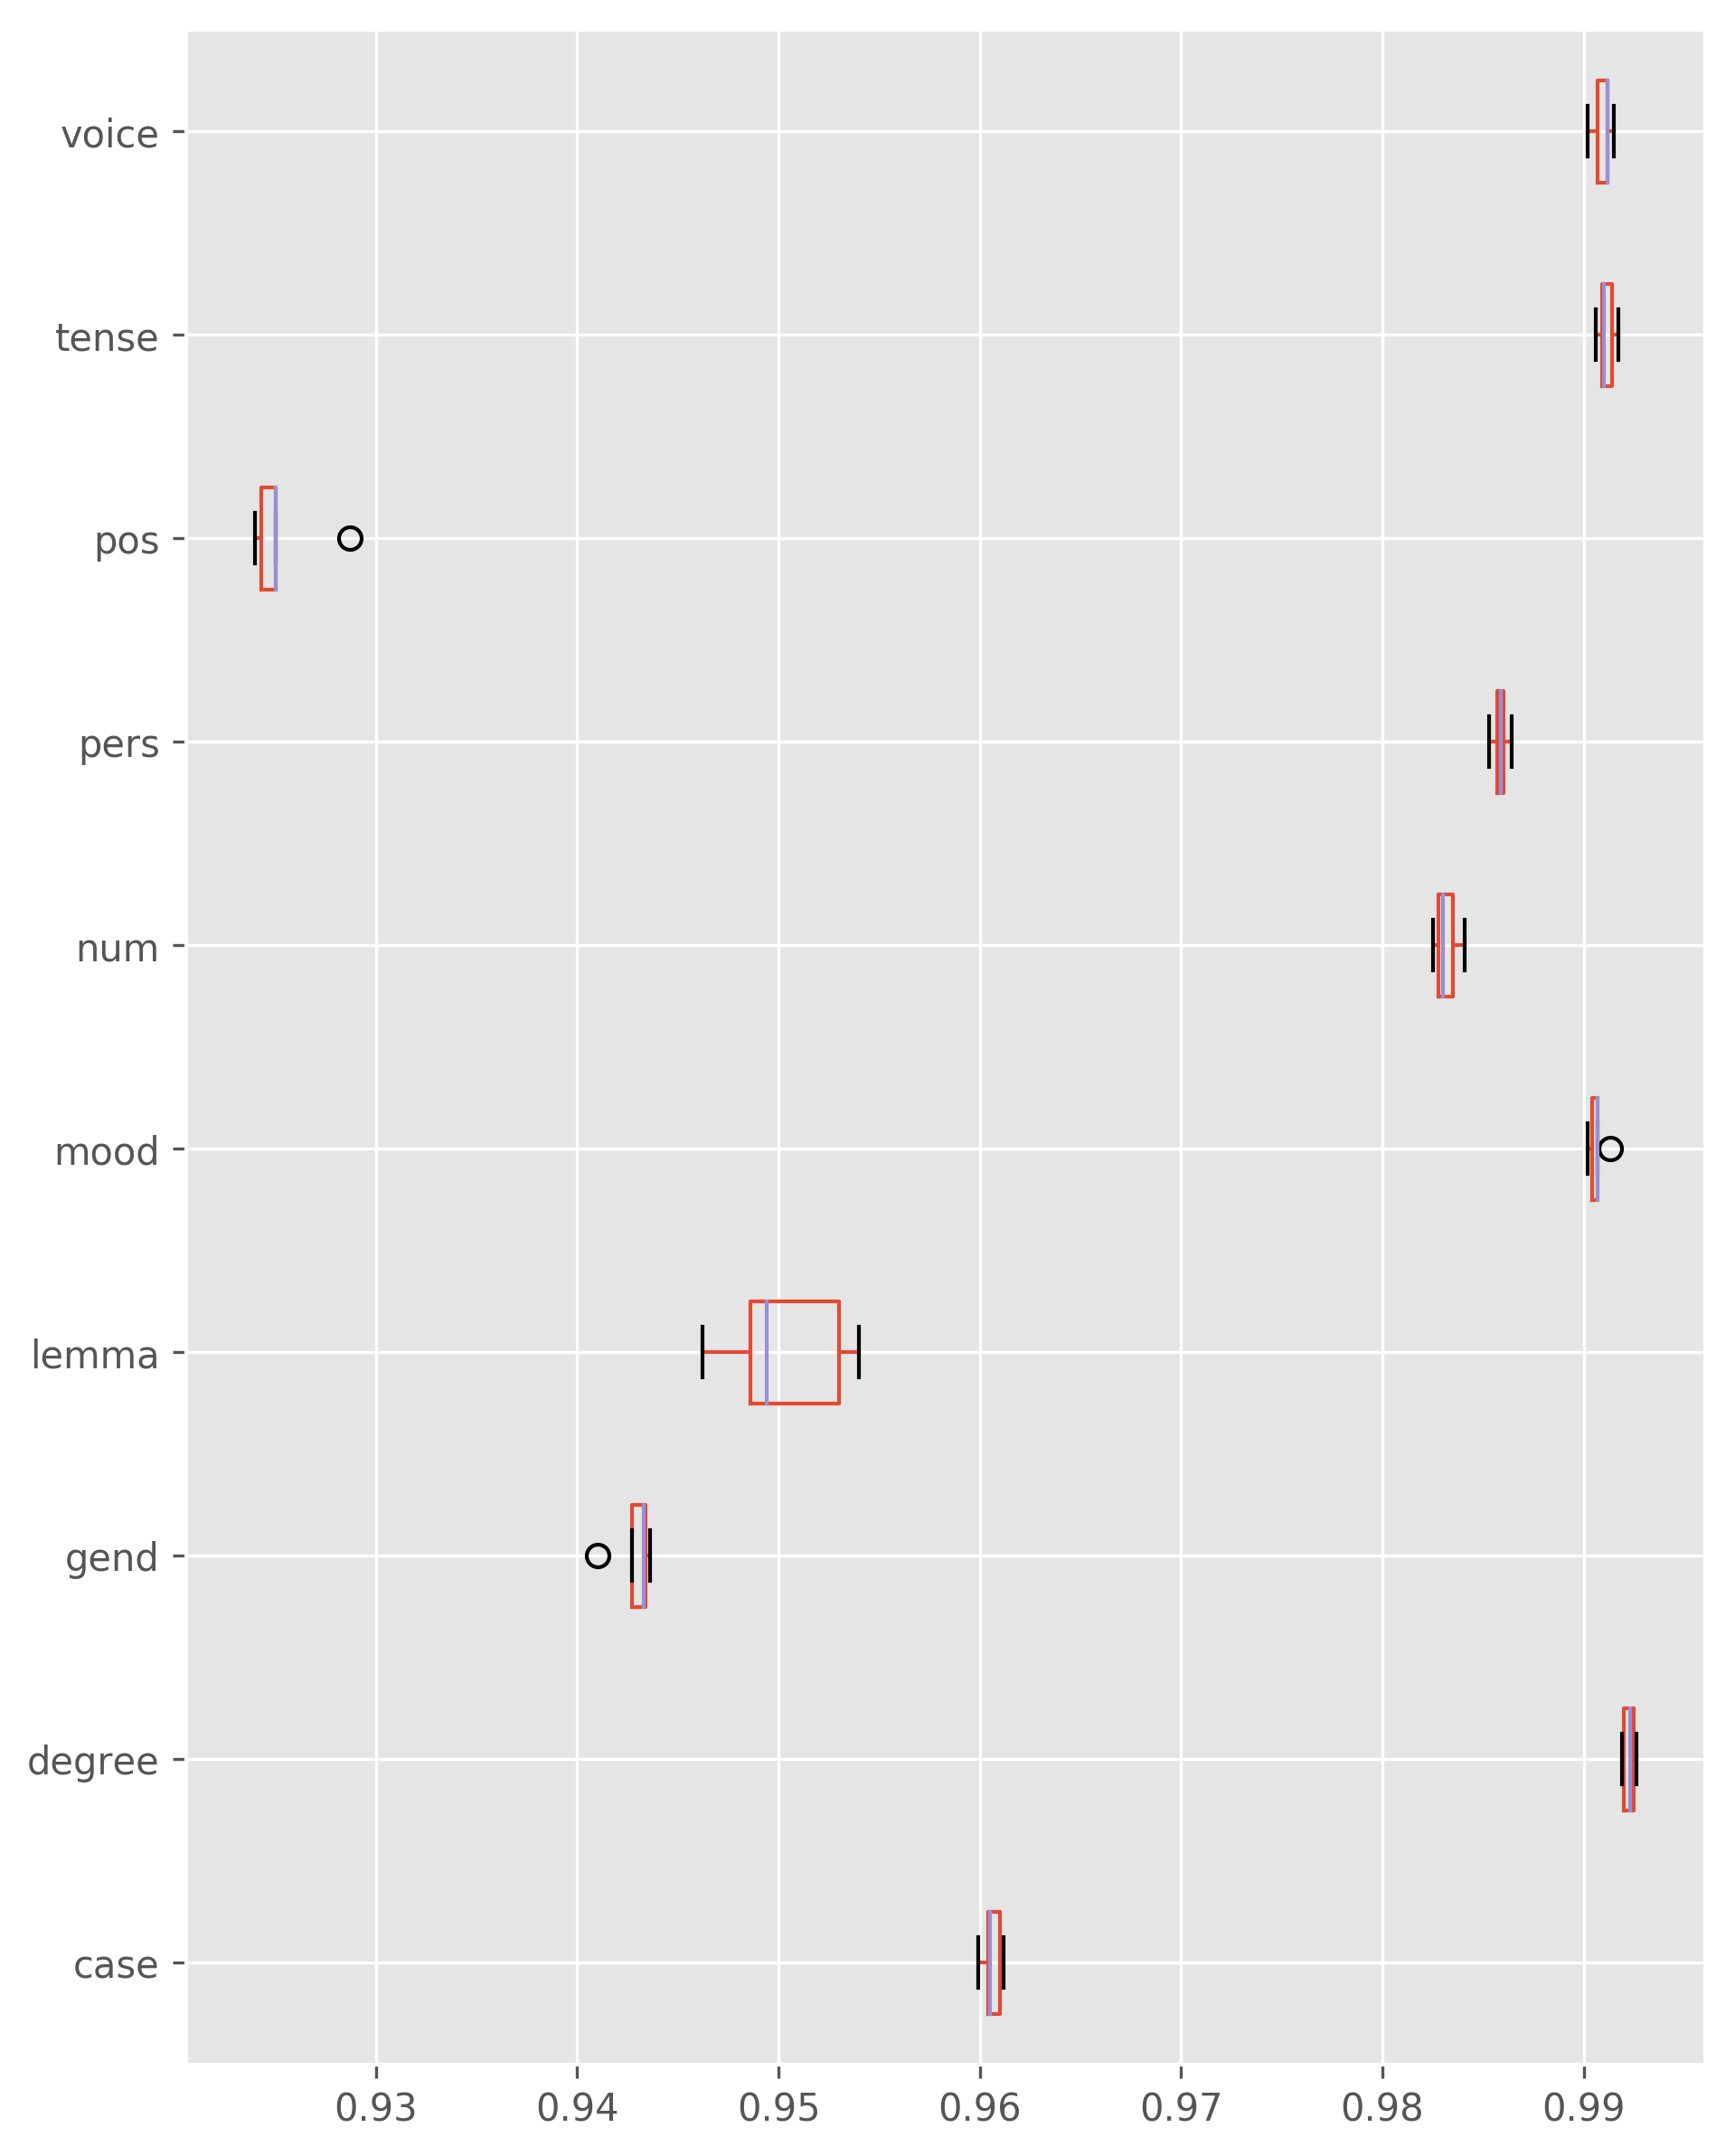

In [38]:
from pandas import DataFrame
import matplotlib.pyplot as plt

def simplify_title(row):
    """Simplify title into a simpler title"""
    # title = row[1]
    # title = title.split("/")[-1].replace(".json", "").replace("1.4.4.a-", "")
    # return [row[0], title] + row[2:]
    return row[1:]
    

models_std = DataFrame(
    [simplify_title(row) for row in table[1:]], 
    columns=table[0][1:]
)
models_std.sort_values(by="task")
#models_std.groupby("conf").std()#["acc"].plot()

plt.style.use('ggplot')
fig = plt.figure(figsize=(7,10), dpi=300)
ax = fig.gca()
models_std.boxplot(column="acc", by="task", ax=ax, vert=False)
ax.set_title("")#Stability of scores accross configuration's runs (5 each)")
ax.set_ylabel("")
ax.set_xlabel("")
fig.suptitle("")
fig.show()

0.09391401956767723 0.0513808381623809
10


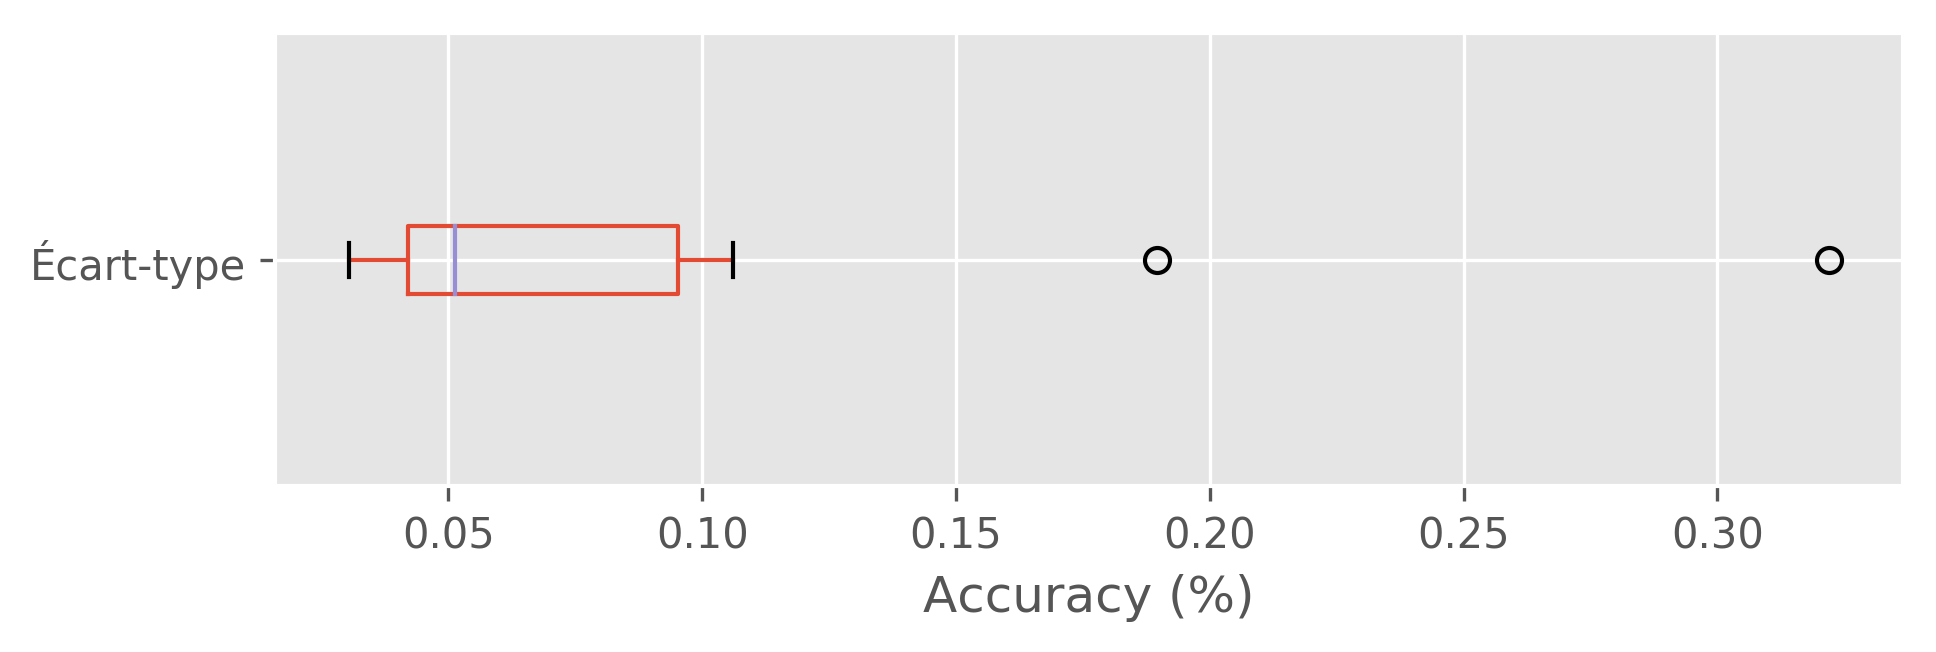

In [39]:
from pandas import Series

fig = plt.figure(figsize=(7,2), dpi=300)
ax = fig.gca()
serie = Series((models_std.groupby("task").acc.std()*100).tolist(), name="Écart-type")
ax = serie.plot.box(ax=ax, vert=False)#*100
ax.set_xlabel("Accuracy (%)")
fig.show()
print(serie.mean(), serie.median())
print(len(models_std.groupby("task")))

# Keeping the best model only

In [60]:
best = {
}

from collections import namedtuple

Infos = namedtuple("Infos", ["task", "tar", "acc", "amb"])
for tar, task, acc, amb, *_ in table[1:]:
    if task not in best:
        best[task] = Infos(task, tar, acc, amb)
        continue
    if best[task].acc < acc:
        best[task] = Infos(task, tar, acc, amb)
    
column = [
    "task", "file", 
    "Accuracy", "Accuracy Ambiguous"
]
table2 = []
for task, values in best.items():
    table2.append(list(values))
    
table2 = sorted(table2, key=lambda x: x[0])  # 2 is acc, 3 amb, 4 tokens
table2 = [column] + table2

In [67]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(table2, tablefmt='html')))

for task_row in table2[1:]:
    print(f"mv {task_row[1]} bests/{task_row[0]}.tar")

task,file,Accuracy,Accuracy Ambiguous
case,./models/greek-case-case-2021_02_05-12_26_05.tar,0.9612,0.8854
degree,./models/greek-degree-degree-2021_02_05-14_17_25.tar,0.9926,0.9596
gend,./models/greek-gend-gend-2021_02_05-17_18_12.tar,0.9436,0.8296
lemma,./models/greek-lemma-lemma-2021_02_09-05_44_29.tar,0.954,0.9097
mood,./models/greek-mood-mood-2021_02_05-22_16_13.tar,0.9913,0.957
num,./models/greek-num-num-2021_02_08-06_35_21.tar,0.9841,0.9589
pers,./models/greek-pers-pers-2021_02_10-16_41_31.tar,0.9864,0.9219
pos,./models/greek-pos-pos-2021_02_09-16_12_14.tar,0.9287,0.8805
tense,./models/greek-tense-tense-2021_02_10-22_22_12.tar,0.9917,0.9588
voice,./models/greek-voice-voice-2021_02_09-21_53_09.tar,0.9915,0.9606


mv ./models/greek-case-case-2021_02_05-12_26_05.tar bests/case.tar
mv ./models/greek-degree-degree-2021_02_05-14_17_25.tar bests/degree.tar
mv ./models/greek-gend-gend-2021_02_05-17_18_12.tar bests/gend.tar
mv ./models/greek-lemma-lemma-2021_02_09-05_44_29.tar bests/lemma.tar
mv ./models/greek-mood-mood-2021_02_05-22_16_13.tar bests/mood.tar
mv ./models/greek-num-num-2021_02_08-06_35_21.tar bests/num.tar
mv ./models/greek-pers-pers-2021_02_10-16_41_31.tar bests/pers.tar
mv ./models/greek-pos-pos-2021_02_09-16_12_14.tar bests/pos.tar
mv ./models/greek-tense-tense-2021_02_10-22_22_12.tar bests/tense.tar
mv ./models/greek-voice-voice-2021_02_09-21_53_09.tar bests/voice.tar


## Comparing Configurations

In [64]:
print(tabulate.tabulate([[row[0]]+row[2:] for row in table2], tablefmt='github'))

|--------|----------|--------------------|
| task   | Accuracy | Accuracy Ambiguous |
| case   | 0.9612   | 0.8854             |
| degree | 0.9926   | 0.9596             |
| gend   | 0.9436   | 0.8296             |
| lemma  | 0.954    | 0.9097             |
| mood   | 0.9913   | 0.957              |
| num    | 0.9841   | 0.9589             |
| pers   | 0.9864   | 0.9219             |
| pos    | 0.9287   | 0.8805             |
| tense  | 0.9917   | 0.9588             |
| voice  | 0.9915   | 0.9606             |
